# MLP + Augmentation

## Description

**Codabench accuracy** : 0.16

**Local test accuracy**: 0.53

**Implementation details**: a simple Multi-Layer Perceptron with a integrated augmentation layers using RandomFlip, RandomTranslation, RandomRotation, RandomZoom

**Purpose** : Proof that augmentation in MLP does not work in your favor, since MLPs are not based on a space invariant transformation (convolution)

## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Parameters

In [ ]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)

## Load Data

In [ ]:
# Cleaned dataset loading with a split in three datasets: training, validation, and test
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

## Model Implementation

In [ ]:
# Setting Learning Rate for the model
LEARNING_RATE = 0.001

In [ ]:
# Model Definition
def build_model():
    # The input layer takes 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Augmentation layer providing random flip, translation, rotation and zoom
    augmentation = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
    ], name='Augmentation')

    x = augmentation(input_layer)

    # Flattening layer for vectorization
    x = tfkl.Flatten()(x)
    #Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Build Model
model = build_model()

# Model Compilation using Adam Optimizer with custom learning rate and
# sparse categorical crossentropy since we are not one-hot encoding.
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tfk.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print Details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │         221,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,192 (864.03 KB)

 Trainable params: 221,192 (864.03 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Training Parameters

In [ ]:
# Training Parameters
EPOCHS = 1000
BATCH_SIZE = 32
PATIENCE = 50

Class Weights

In [ ]:
# Computing the class weights in order to balance the class imbalanceness
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

Callbacks

In [ ]:
# Implementation of early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
callbacks = [early_stopping]

Training

In [ ]:
# Actual training of the model with the given parameters
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val,y_val),
                    class_weight=class_weight_dict,
                    callbacks=callbacks).history

Epoch 1/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - accuracy: 0.1823 - loss: 2656.4753 - val_accuracy: 0.1501 - val_loss: 1090.9111
Epoch 2/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.2809 - loss: 943.5955 - val_accuracy: 0.4034 - val_loss: 977.7814
Epoch 3/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.3108 - loss: 850.4302 - val_accuracy: 0.3641 - val_loss: 464.0106
Epoch 4/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.3235 - loss: 805.7324 - val_accuracy: 0.3487 - val_loss: 1392.2832
Epoch 5/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.3052 - loss: 1188.8572 - val_accuracy: 0.4034 - val_loss: 738.0408
Epoch 6/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.3688 - loss: 700.4675 - val_accuracy: 0.2901 - val_loss: 844.2538
Epoch 7/1000
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.3653 - loss: 805.2955 - val_accuracy: 0.2793 - val_loss: 904.1796
Epoch 8/1000
225/225 ━━━━━━━━━━━━━━━━━

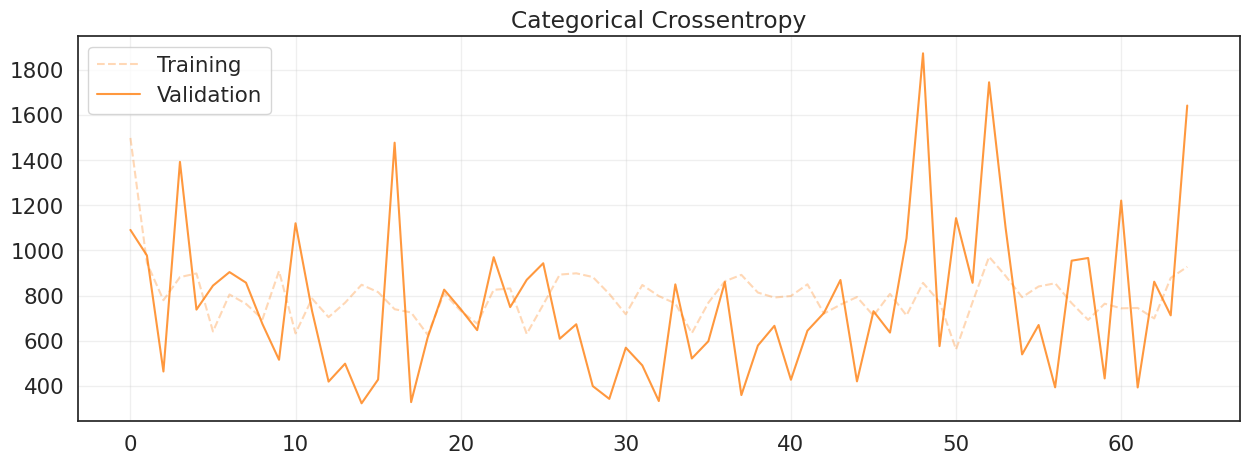

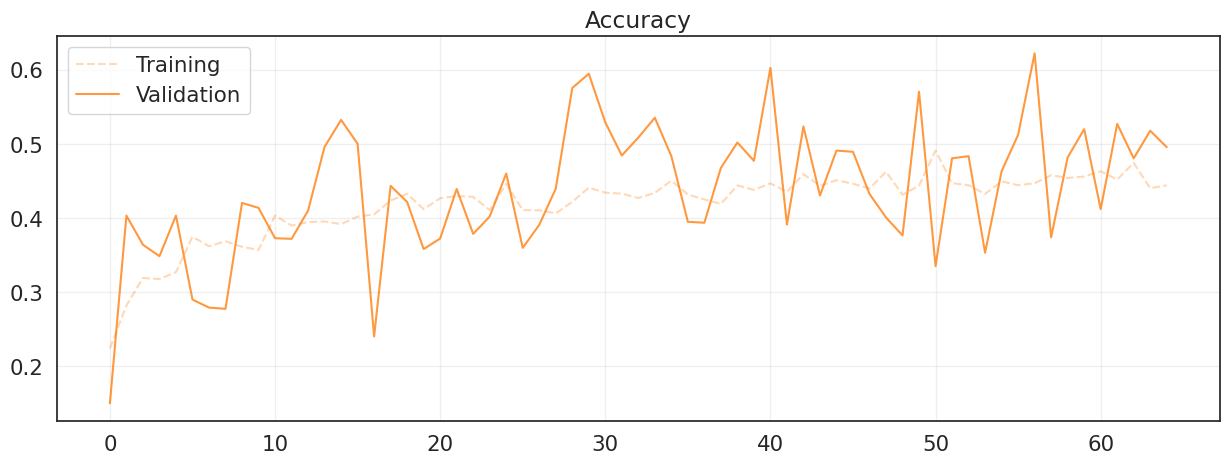

In [ ]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [ ]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"mlp_aug_weighted_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving mlp_aug_weighted_62.25.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.4979
Precision score over the test set: 0.3538
Recall score over the test set: 0.4979
F1 score over the test set: 0.3997


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
